In [36]:
# ────────────────────────────── 0. Imports ───────────────────────────────
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (f1_score, precision_recall_fscore_support,
                             classification_report, confusion_matrix,
                             precision_recall_curve, roc_curve, auc)

import tensorflow as tf
from tensorflow import keras
from keras.layers import (Input, Embedding, Dense, Dropout, LayerNormalization,
                          Add, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D,
                          concatenate, MultiHeadAttention, GlobalAveragePooling1D)
from keras.callbacks import Callback
from keras.optimizers import Adam
from keras import backend as K

from datetime import datetime
LOG_DIR = f"logs/{datetime.now():%Y%m%d-%H%M%S}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(
        log_dir=LOG_DIR,
        histogram_freq=1,
        write_graph=True,
        write_images=False)

In [3]:
# ───────────────────────────── 1. Hyper-params ────────────────────────────
MAX_WORDS   = 20_000       # size of the word vocabulary
MAX_LEN     = 32           # sequence length after padding / truncation
BATCH_SIZE  = 32
EPOCHS      = 20
PATIENCE_ES = 3            # EarlyStopping patience
PATIENCE_LR = 2            # LR-scheduler patience
SEED        = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
# ───────────────────────────── 2. Load & Clean ───────────────────────────
DATA_DIR = Path('../data/goemotions')

df = pd.concat([pd.read_csv(p) for p in DATA_DIR.glob('goemotions_*.csv')],
               ignore_index=True)

def basic_clean(text: str) -> str:
    """Lower-case, drop HTML, punctuation, duplicate spaces."""
    text = re.sub(r'<.*?>', '', text.lower())          # remove HTML
    text = re.sub(r'[^a-z0-9\s]', '', text)            # keep alphanum/space
    return re.sub(r'\s+', ' ', text).strip()

df['clean_text'] = df['text'].astype(str).apply(basic_clean)

# -------------------------------------------------------------------------
# Make sure emotion columns are numeric (int8 saves RAM)
# -------------------------------------------------------------------------
META = {'text','id','author','subreddit','link_id','parent_id',
        'created_utc','rater_id','example_very_unclear'}
label_cols = [c for c in df.columns if c not in META and c != 'clean_text']
df[label_cols] = df[label_cols].astype('int8')

In [6]:
# ───────────────────────────── 3. Train / Val / Test split ───────────────
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=SEED)
val_df,   test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED)

In [7]:
# ───────────────────────────── 4. Tokenisation ───────────────────────────
# 4-a Build vocabulary on the training set
counter = Counter(); [counter.update(t.split()) for t in train_df['clean_text']]
vocab = [w for w,_ in counter.most_common(MAX_WORDS-1)]
word2idx = {w:i+2 for i,w in enumerate(vocab)}  # 0=PAD,1=OOV
VOCAB_SIZE = MAX_WORDS + 2

def text_to_ids(txt): return [word2idx.get(tok,1) for tok in txt.split()]
def pad32(seq): return (seq[:MAX_LEN] + [0]*MAX_LEN)[:MAX_LEN]
def to_tensor(series): return np.array([pad32(text_to_ids(t)) for t in series],
                                       dtype=np.int16)

train_x = to_tensor(train_df['clean_text'])
val_x   = to_tensor(val_df['clean_text'])
test_x  = to_tensor(test_df['clean_text'])

train_y = train_df[label_cols].values
val_y   = val_df[label_cols].values
test_y  = test_df[label_cols].values
N_LABELS = len(label_cols)

In [8]:
# ─────────── 4-bis-prep. Derive positive / negative flags if missing ─────
if 'positive' not in df.columns:
    pos_emotions = ['admiration','amusement','approval','caring','desire',
                    'excitement','gratitude','joy','love','optimism',
                    'pride','relief']
    neg_emotions = ['anger','annoyance','confusion','disappointment',
                    'disapproval','disgust','embarrassment','fear','grief',
                    'nervousness','remorse','sadness']
    missing = set(pos_emotions + neg_emotions) - set(label_cols)
    if missing:
        raise ValueError(f'Missing emotion columns: {missing}')
    df['positive'] = (df[pos_emotions].sum(axis=1) > 0).astype('int8')
    df['negative'] = (df[neg_emotions].sum(axis=1) > 0).astype('int8')
    print('Derived positive / negative flags.')
else:
    print('positive / negative already present.')

Derived positive / negative flags.


In [9]:
# ░░░░░░░░░░░ 4-bis. Binary Sentiment Dataset (GoEmotions) ░░░░░░░░░░░
print('\n=== Building binary sentiment subset ===')

mask_bin = (df['positive']==1) ^ (df['negative']==1)
sent_df  = df.loc[mask_bin, ['clean_text','positive']].copy()
sent_df.rename(columns={'positive':'label'}, inplace=True)

X_train_txt, X_test_txt, y_train_bin, y_test_bin = train_test_split(
    sent_df['clean_text'], sent_df['label'],
    test_size=0.2, random_state=SEED, stratify=sent_df['label']
)
X_train_bin = to_tensor(X_train_txt)
X_test_bin  = to_tensor(X_test_txt)

print(f'Train {len(X_train_bin):,} samples  pos-ratio {y_train_bin.mean():.2f}')

def build_sentiment_cnn():
    inp = Input((MAX_LEN,))
    x   = Embedding(VOCAB_SIZE, 128)(inp)
    x   = Conv1D(128, 5, activation='relu')(x)
    x   = GlobalMaxPooling1D()(x)
    x   = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)
    m   = keras.Model(inp, out)
    m.compile(Adam(1e-3), 'binary_crossentropy', metrics=['accuracy'])
    return m

sent_cnn = build_sentiment_cnn()
sent_cnn.fit(X_train_bin, y_train_bin,
             validation_split=0.1,
             epochs=6, batch_size=128,
             callbacks=[keras.callbacks.EarlyStopping(patience=2,
                                                      restore_best_weights=True)],
             verbose=2)
print(f'Binary sentiment accuracy: {sent_cnn.evaluate(X_test_bin, y_test_bin, verbose=0)[1]:.3f}')
sent_cnn.save('sentiment_goemotions_cnn.keras')
print('Saved -> sentiment_goemotions_cnn.keras\n')


=== Building binary sentiment subset ===
Train 104,800 samples  pos-ratio 0.58
Epoch 1/6
737/737 - 49s - 67ms/step - accuracy: 0.7819 - loss: 0.4504 - val_accuracy: 0.8282 - val_loss: 0.3885
Epoch 2/6
737/737 - 48s - 66ms/step - accuracy: 0.8477 - loss: 0.3513 - val_accuracy: 0.8342 - val_loss: 0.3895
Epoch 3/6
737/737 - 46s - 62ms/step - accuracy: 0.8701 - loss: 0.3056 - val_accuracy: 0.8339 - val_loss: 0.4118
Binary sentiment accuracy: 0.823
Saved -> sentiment_goemotions_cnn.keras



In [10]:
# ───────────────────────────── 5. Class Weights ──────────────────────────
pos = train_y.sum(axis=0)
neg = len(train_y) - pos
# inverse frequency; cap very rare labels to 25× weight
class_weight = {i: float(np.clip(neg[i] / pos[i], 1.0, 25.0))
                for i in range(N_LABELS)}

In [11]:
# ───────────────────────────── 6. Macro-F1 Callback ──────────────────────
class MacroF1(Callback):
    """Compute macro-F1 on validation set after each epoch."""
    def __init__(self, val_data):
        super().__init__()
        self.val_x, self.val_y = val_data
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        preds = (self.model.predict(self.val_x, verbose=0) > 0.5).astype(int)
        f1 = f1_score(self.val_y, preds, average='macro')
        self.history.append(f1)
        print(f' — val_macro_f1: {f1:.4f}')

In [12]:
# ───────────────────────────── 7. Encoder Blocks ─────────────────────────
def build_lstm(emb_dim=100, units=128):
    inp = Input(shape=(MAX_LEN,))
    x   = Embedding(VOCAB_SIZE, emb_dim)(inp)
    x   = Bidirectional(LSTM(units))(x)
    x   = Dropout(0.5)(x)
    out = Dense(N_LABELS, activation='sigmoid')(x)
    model = keras.Model(inp, out)
    model.compile(Adam(1e-3), 'binary_crossentropy', metrics=['binary_accuracy'])
    return model

def build_cnn(emb_dim=100, filters=64, kernel_sizes=(3,4,5)):
    inp = Input(shape=(MAX_LEN,))
    x   = Embedding(VOCAB_SIZE, emb_dim)(inp)
    pooled = [GlobalMaxPooling1D()(Conv1D(filters, k, activation='relu')(x))
              for k in kernel_sizes]
    x   = concatenate(pooled)
    x   = Dropout(0.5)(x)
    out = Dense(N_LABELS, activation='sigmoid')(x)
    model = keras.Model(inp, out)
    model.compile(Adam(1e-3), 'binary_crossentropy', metrics=['binary_accuracy'])
    return model

# ---- tiny Transformer encoder ------------------------------------------
def tfm_block(x, heads=4, proj=64, mlp_dim=128):
    """One transformer encoder block with residual connections."""
    attn_out = MultiHeadAttention(num_heads=heads, key_dim=proj)(x, x)
    x = LayerNormalization()(Add()([x, attn_out]))

    mlp_out = Dense(mlp_dim, activation='relu')(x)
    mlp_out = Dense(x.shape[-1])(mlp_out)
    return LayerNormalization()(Add()([x, mlp_out]))

def build_transformer(emb_dim=128, blocks=2, heads=4):
    inp = Input(shape=(MAX_LEN,))
    tok_emb = Embedding(VOCAB_SIZE, emb_dim)(inp)
    # learnable positional embedding
    pos_emb = Embedding(MAX_LEN, emb_dim)(tf.range(MAX_LEN)[None, :])
    x = tok_emb + pos_emb

    for _ in range(blocks):
        x = tfm_block(x, heads, emb_dim // heads, emb_dim * 2)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    out = Dense(N_LABELS, activation='sigmoid')(x)
    model = keras.Model(inp, out)
    model.compile(Adam(1e-3), 'binary_crossentropy', metrics=['binary_accuracy'])
    return model
# ------------------------------------------------------------------------

# Common callbacks
CALLBACKS = [
    keras.callbacks.EarlyStopping(patience=PATIENCE_ES, restore_best_weights=True,
                                  min_delta=1e-4),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=PATIENCE_LR,
                                      min_lr=1e-6, verbose=1),
    tensorboard_cb   
]

def train_model(build_fn, name):
    """Utility: build, fit, return trained model + F1 curve."""
    K.clear_session()                                   # free GPU/CPU memory
    model = build_fn()
    f1_cb = MacroF1((val_x, val_y))
    model.fit(train_x, train_y,
              validation_data=(val_x, val_y),
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              class_weight=class_weight,
              callbacks=[f1_cb, *CALLBACKS],
              verbose=2)
    return model, f1_cb.history

In [13]:
# ───────────────────────────── 7.1 Hyperparameter Tuning ────────────────────────
def hyperparameter_search_cnn_efficient():
    """More efficient grid search for CNN hyperparameters."""
    print("\n=== CNN Hyperparameter Tuning (Efficient) ===")
    best_f1 = 0
    best_params = {}
    results = []
    
    # Check if GPU is available
    gpu_available = len(tf.config.list_physical_devices('GPU')) > 0
    print(f"GPU available: {gpu_available}")
    
    # Smaller parameter grid
    param_grid = {
        'emb_dim': [100],          # Reduced from [50, 100, 200]
        'filters': [64, 128],       # Reduced from [32, 64, 128]
        'dropout': [0.5]            # Reduced from [0.3, 0.5, 0.7]
    }
    
    # Create a smaller subset for faster tuning
    sample_size = min(5000, len(train_x))
    indices = np.random.choice(len(train_x), sample_size, replace=False)
    train_x_sample = train_x[indices]
    train_y_sample = train_y[indices]
    
    print(f"Using {sample_size} samples for tuning (from {len(train_x)} total)")
    
    # Display total combinations
    total_combinations = len(param_grid['emb_dim']) * len(param_grid['filters']) * len(param_grid['dropout'])
    print(f"Testing {total_combinations} parameter combinations")
    
    for emb_dim in param_grid['emb_dim']:
        for filters in param_grid['filters']:
            for dropout in param_grid['dropout']:
                params = {
                    'emb_dim': emb_dim,
                    'filters': filters,
                    'dropout': dropout
                }
                print(f"\nTesting: emb_dim={emb_dim}, filters={filters}, dropout={dropout}")
                
                # Define model with these hyperparameters
                def build_model():
                    inp = Input(shape=(MAX_LEN,))
                    x = Embedding(VOCAB_SIZE, emb_dim)(inp)
                    pooled = [GlobalMaxPooling1D()(Conv1D(filters, k, activation='relu')(x))
                             for k in [3, 4, 5]]
                    x = concatenate(pooled)
                    x = Dropout(dropout)(x)
                    out = Dense(N_LABELS, activation='sigmoid')(x)
                    model = keras.Model(inp, out)
                    model.compile(Adam(1e-3), 'binary_crossentropy', metrics=['binary_accuracy'])
                    return model
                
                # Train with fewer epochs for hyperparameter search
                K.clear_session()
                model = build_model()
                f1_cb = MacroF1((val_x, val_y))
                
                history = model.fit(
                    train_x_sample, train_y_sample,  # Using sampled data
                    validation_data=(val_x, val_y),
                    epochs=3,  # Reduced epochs for faster tuning
                    batch_size=BATCH_SIZE,
                    callbacks=[f1_cb],  # Reduced callbacks
                    class_weight=class_weight,
                    verbose=1
                )
                
                # Get best F1 score
                val_f1 = max(f1_cb.history)
                
                # Track results
                results.append({**params, 'val_f1': val_f1})
                
                if val_f1 > best_f1:
                    best_f1 = val_f1
                    best_params = params
                
                # Free memory
                K.clear_session()
    
    # Convert results to DataFrame for easier analysis
    results_df = pd.DataFrame(results)
    
    print(f"\nBest parameters: {best_params}, F1: {best_f1:.4f}")
    print("\nAll configurations:")
    print(results_df.sort_values('val_f1', ascending=False).to_string(index=False))
    
    return best_params

In [14]:
# ───────────────────────────── 7.2 Cross-Validation ────────────────────────
def cross_validate_model_efficient(build_fn, name, k=3):
    """Perform k-fold cross-validation on the model with efficiency optimizations."""
    print(f"\n=== {name} {k}-Fold Cross-Validation (Efficient) ===")
    
    # Create k folds with fewer splits
    kf = KFold(n_splits=k, shuffle=True, random_state=SEED)
    
    # Combine train and validation data for CV
    combined_x = np.concatenate([train_x, val_x])
    combined_y = np.concatenate([train_y, val_y])
    
    # Take a sample to speed up cross-validation
    sample_size = min(10000, len(combined_x))
    indices = np.random.choice(len(combined_x), sample_size, replace=False)
    combined_x_sample = combined_x[indices]
    combined_y_sample = combined_y[indices]
    
    print(f"Using {sample_size} samples for CV (from {len(combined_x)} total)")
    
    fold_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(combined_x_sample)):
        print(f"\nTraining fold {fold+1}/{k}")
        
        # Get fold data
        fold_train_x = combined_x_sample[train_idx]
        fold_train_y = combined_y_sample[train_idx]
        fold_val_x = combined_x_sample[val_idx]
        fold_val_y = combined_y_sample[val_idx]
        
        # Build and train model
        K.clear_session()
        model = build_fn()
        f1_cb = MacroF1((fold_val_x, fold_val_y))
        
        model.fit(
            fold_train_x, fold_train_y,
            validation_data=(fold_val_x, fold_val_y),
            epochs=5,  # Further reduced epochs
            batch_size=BATCH_SIZE * 2,  # Larger batch size for speed
            callbacks=[f1_cb],  # Minimal callbacks
            class_weight=class_weight,
            verbose=1
        )
        
        # Get best F1 score
        best_f1 = max(f1_cb.history)
        fold_scores.append(best_f1)
        
        print(f"Fold {fold+1} best F1: {best_f1:.4f}")
    
    # Calculate aggregate statistics
    mean_f1 = np.mean(fold_scores)
    std_f1 = np.std(fold_scores)
    
    # Print summary
    print(f"\n{name} Cross-validation results:")
    print(f"F1 scores: {[f'{x:.4f}' for x in fold_scores]}")
    print(f"Mean F1: {mean_f1:.4f}, Std: {std_f1:.4f}")
    
    return {'f1_scores': fold_scores, 'mean_f1': mean_f1, 'std_f1': std_f1}

In [15]:
# ───────────────────────────── 8. Train all three encoders ───────────────
lstm_model, hist_lstm = train_model(build_lstm, 'LSTM')
cnn_model,  hist_cnn  = train_model(build_cnn,  'CNN')
tfm_model,  hist_tfm  = train_model(build_transformer, 'TFM')

Epoch 1/20
 — val_macro_f1: 0.1276
5281/5281 - 332s - 63ms/step - binary_accuracy: 0.9590 - loss: 2.3058 - val_binary_accuracy: 0.9600 - val_loss: 0.1357 - learning_rate: 0.0010
Epoch 2/20
 — val_macro_f1: 0.1786
5281/5281 - 367s - 70ms/step - binary_accuracy: 0.9598 - loss: 1.9936 - val_binary_accuracy: 0.9601 - val_loss: 0.1316 - learning_rate: 0.0010
Epoch 3/20
 — val_macro_f1: 0.2021
5281/5281 - 454s - 86ms/step - binary_accuracy: 0.9601 - loss: 1.8989 - val_binary_accuracy: 0.9602 - val_loss: 0.1303 - learning_rate: 0.0010
Epoch 4/20
 — val_macro_f1: 0.2195
5281/5281 - 297s - 56ms/step - binary_accuracy: 0.9603 - loss: 1.8338 - val_binary_accuracy: 0.9600 - val_loss: 0.1308 - learning_rate: 0.0010
Epoch 5/20
 — val_macro_f1: 0.2279

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5281/5281 - 383s - 73ms/step - binary_accuracy: 0.9605 - loss: 1.7816 - val_binary_accuracy: 0.9599 - val_loss: 0.1311 - learning_rate: 0.0010
Epoch 6/20
 — val_macro_f1: 0.245

In [20]:
# ───────────────────────────── 9. Per-class threshold tuning ─────────────
# Use Transformer as best model; you can reuse this function for others.
val_prob = tfm_model.predict(val_x, batch_size=256, verbose=0)
opt_thr  = np.zeros(N_LABELS)

for i in range(N_LABELS):
    precision, recall, thresh = precision_recall_curve(val_y[:, i], val_prob[:, i])
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    opt_thr[i] = thresh[f1.argmax()]

np.save('opt_thresholds.npy', opt_thr)   #  -> used later in Part 2/3

In [21]:
# ───────────────────────────── 10. Final Test metrics ────────────────────
def evaluate(model, name, thr=None):
    prob = model.predict(test_x, batch_size=256, verbose=0)
    pred = (prob >= thr) if thr is not None else (prob > 0.5)
    pred = pred.astype(int)
    macro = f1_score(test_y, pred, average='macro')
    micro = f1_score(test_y, pred, average='micro')
    print(f'{name:11s} | Macro-F1 {macro:.4f} | Micro-F1 {micro:.4f}')

print('\n── Test set with fixed 0.5 threshold ──')
evaluate(lstm_model, 'Bi-LSTM')
evaluate(cnn_model,  '1D-CNN')

print('\n── Test set with tuned thresholds (Transformer) ──')
evaluate(tfm_model, 'Transformer', opt_thr)


── Test set with fixed 0.5 threshold ──
Bi-LSTM     | Macro-F1 0.1975 | Micro-F1 0.2367
1D-CNN      | Macro-F1 0.2248 | Micro-F1 0.2446

── Test set with tuned thresholds (Transformer) ──
Transformer | Macro-F1 0.3387 | Micro-F1 0.3912


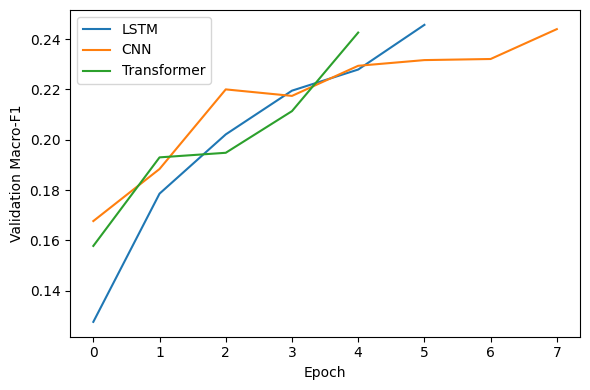

In [22]:
# ───────────────────────────── 11. F1 curves plot ────────────────────────
plt.figure(figsize=(6, 4))
plt.plot(hist_lstm, label='LSTM')
plt.plot(hist_cnn,  label='CNN')
plt.plot(hist_tfm,  label='Transformer')
plt.ylabel('Validation Macro-F1'); plt.xlabel('Epoch'); plt.legend(); plt.tight_layout()
plt.show()

In [34]:
# ───────────────────────────── 12. Visualization helpers ─────────────────────────────
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_fscore_support, f1_score

# ───────────────────────── plot_metrics_by_emotion ─────────────────────────
def plot_metrics_by_emotion(metrics_df, title="Model Performance by Emotion", n_emotions=10):
    """
    Bar-chart the precision, recall and F1 scores for the top-ranking emotions.

    Args:
        metrics_df (pd.DataFrame): output of evaluate_model_comprehensive
        title (str): plot title
        n_emotions (int): number of emotions to visualise
    """
    plot_df = metrics_df.head(n_emotions).copy()

    # reshape to long form – three rows per emotion (Prec, Rec, F1)
    long = []
    for _, row in plot_df.iterrows():
        for metric in ("Precision", "Recall", "F1-Score"):
            long.append((row["Emotion"], metric, row[metric]))
    emo, met, val = zip(*long)

    plt.figure(figsize=(14, 8))
    x = np.arange(len(plot_df))          # groups = emotions
    width = 0.25

    for i, metric in enumerate(("Precision", "Recall", "F1-Score")):
        offset = (i - 1) * width         # −width, 0, +width
        plt.bar(
            x + offset,
            [v for (e, m, v) in long if m == metric],
            width=width,
            label=metric
        )

    # annotate thresholds & support
    for i, r in plot_df.iterrows():
        plt.text(i, 1.05, f'thr={r.Threshold:.2f}\nn={r.Support}', ha='center')

    plt.title(title, fontsize=16)
    plt.xticks(x, plot_df["Emotion"], rotation=45, ha='right')
    plt.ylim(0, 1.15)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{title.lower().replace(' ', '_')}.png", dpi=300)
    plt.show()


# ───────────────────────── plot_confusion_matrix_for_class ─────────────────
def plot_confusion_matrix_for_class(model, x_test, y_test,
                                    class_idx, class_name,
                                    threshold=0.5):
    """
    Draw a 2×2 confusion-matrix heat-map for a single emotion label.

    Args:
        model: trained Keras model
        x_test: encoded test features
        y_test: one-hot test labels
        class_idx (int): index of the target label
        class_name (str): human-readable name
        threshold (float): decision threshold
    """
    y_prob = model.predict(x_test, batch_size=256, verbose=0)[:, class_idx]
    y_pred = (y_prob >= threshold).astype(int)
    y_true = y_test[:, class_idx]
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, cmap="Blues")
    plt.colorbar()
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.yticks([0, 1], ['Negative', 'Positive'])
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.title(f'Confusion Matrix – {class_name}')

    # cell annotations
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, f'{v}', ha='center', va='center', color='black')

    plt.tight_layout()
    plt.savefig(f"confusion_matrix_{class_name.lower()}.png", dpi=300)
    plt.show()


# ───────────────────────── analyze_error_patterns ─────────────────────────
def analyze_error_patterns(model, x_test, y_test, label_cols, thresholds=None):
    """
    Analyse false-positive / false-negative counts and co-occurrence patterns.

    Re-implemented without seaborn.
    """
    # predictions
    y_prob = model.predict(x_test, batch_size=256, verbose=0)
    if thresholds is not None:
        y_pred = (y_prob >= thresholds).astype(int)
    else:
        y_pred = (y_prob > 0.5).astype(int)

    # FP / FN counts
    fp_counts = ((y_pred == 1) & (y_test == 0)).sum(axis=0)
    fn_counts = ((y_pred == 0) & (y_test == 1)).sum(axis=0)

    error_df = (
        pd.DataFrame({
            'Emotion': label_cols,
            'False Positives': fp_counts,
            'False Negatives': fn_counts
        })
        .assign(Total_Errors=lambda d: d['False Positives'] + d['False Negatives'])
        .sort_values('Total_Errors', ascending=False)
    )

    print("\nTop 5 classes with most errors:")
    print(error_df.head(5).to_string(index=False))

    # ───────── plot top-10 error distribution ─────────
    error_df_plot = error_df.head(10).copy()
    plt.figure(figsize=(12, 6))
    x = np.arange(len(error_df_plot))
    width = 0.35
    plt.bar(x - width/2, error_df_plot['False Positives'], width, label='False Positives')
    plt.bar(x + width/2, error_df_plot['False Negatives'], width, label='False Negatives')
    plt.xlabel('Emotion'); plt.ylabel('Count')
    plt.title('Error Distribution by Emotion Class')
    plt.xticks(x, error_df_plot['Emotion'], rotation=45, ha='right')
    plt.legend(); plt.tight_layout()
    plt.savefig("error_distribution.png", dpi=300)
    plt.show()

    return error_df


Running CNN hyperparameter tuning...

Running cross-validation on models...

Training final models...

Running comprehensive evaluation...

==================== BiLSTM Evaluation ====================
Macro-Precision: 0.4279 | Macro-Recall: 0.1560 | Macro-F1: 0.1975
Micro-Precision: 0.6120 | Micro-Recall: 0.1467 | Micro-F1: 0.2367

Top 5 classes:
   Emotion  Precision  Recall  F1-Score  Support  Threshold
 gratitude     0.8824  0.7536    0.8129     1185        0.5
      love     0.5923  0.6847    0.6352      834        0.5
 amusement     0.5842  0.6171    0.6002      922        0.5
      fear     0.5572  0.3601    0.4375      311        0.5
admiration     0.7065  0.2046    0.3173     1706        0.5

Bottom 5 classes:
       Emotion  Precision  Recall  F1-Score  Support  Threshold
         pride        0.0     0.0       0.0      120        0.5
   nervousness        0.0     0.0       0.0      175        0.5
     annoyance        0.0     0.0       0.0     1374        0.5
disappointment  

/var/folders/w_/0qjwbm551ls6swp_lf0j1b600000gn/T/ipykernel_1631/816644804.py:48: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


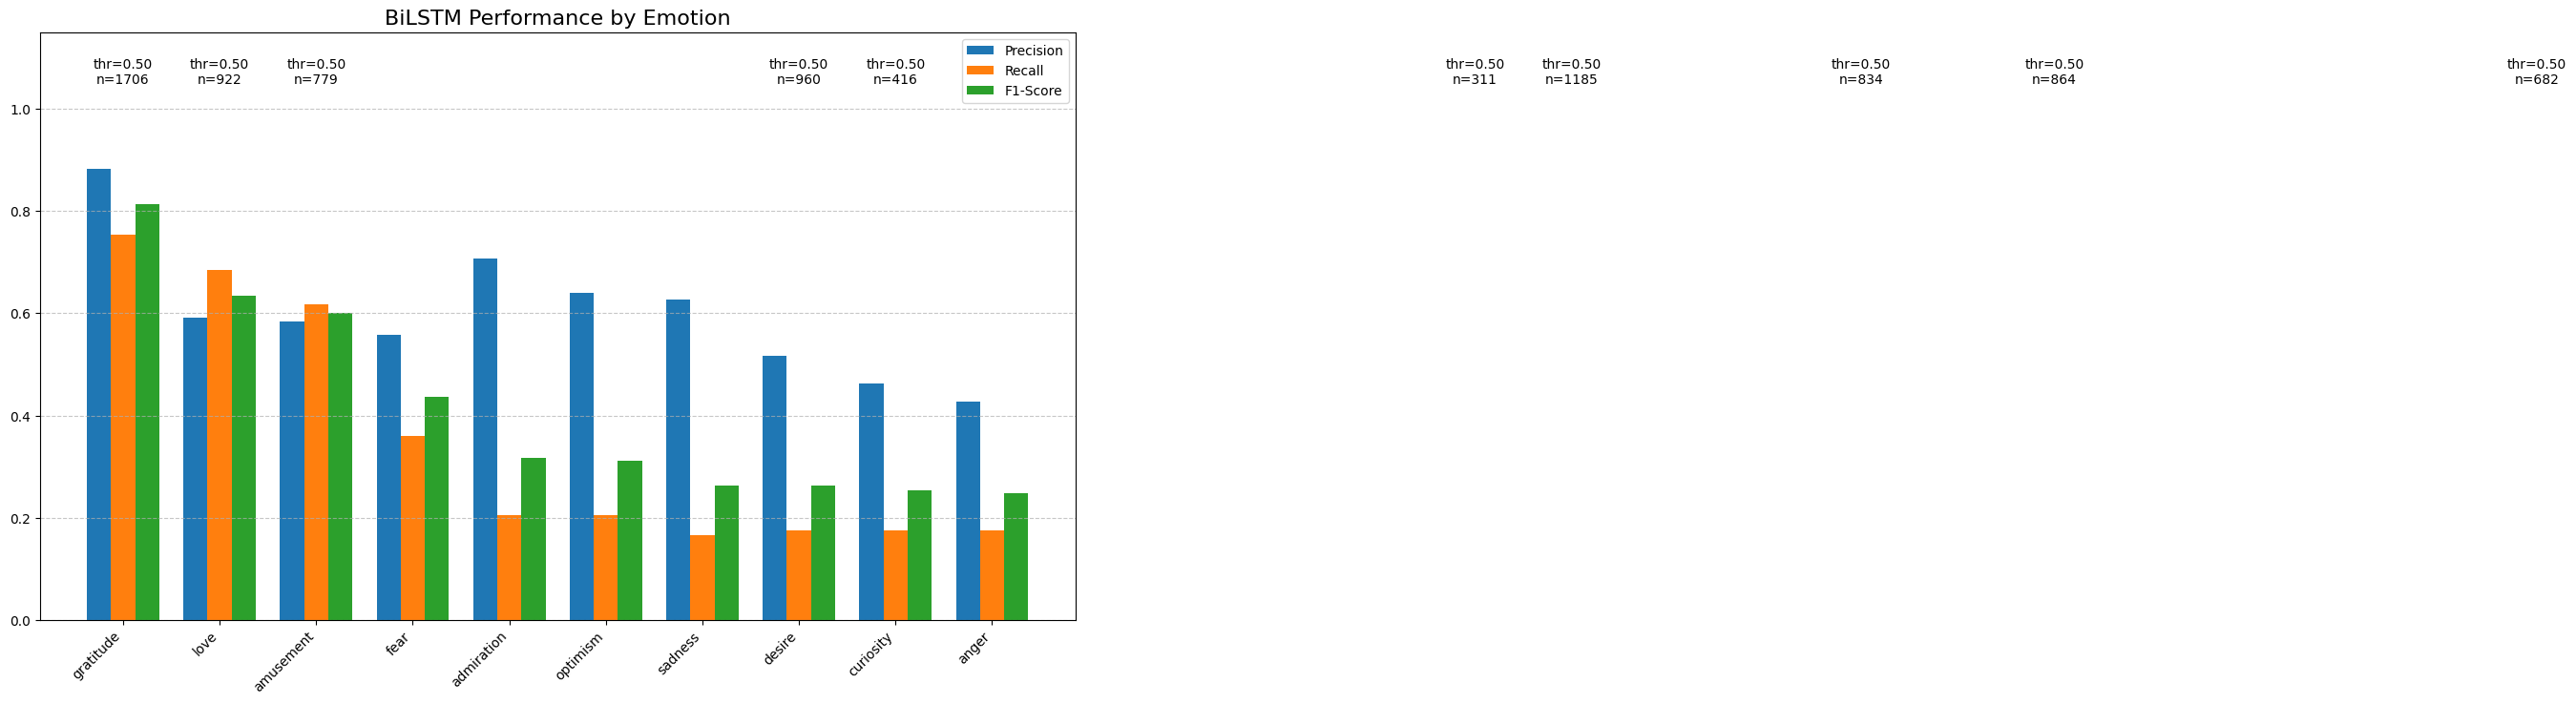

/var/folders/w_/0qjwbm551ls6swp_lf0j1b600000gn/T/ipykernel_1631/816644804.py:48: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


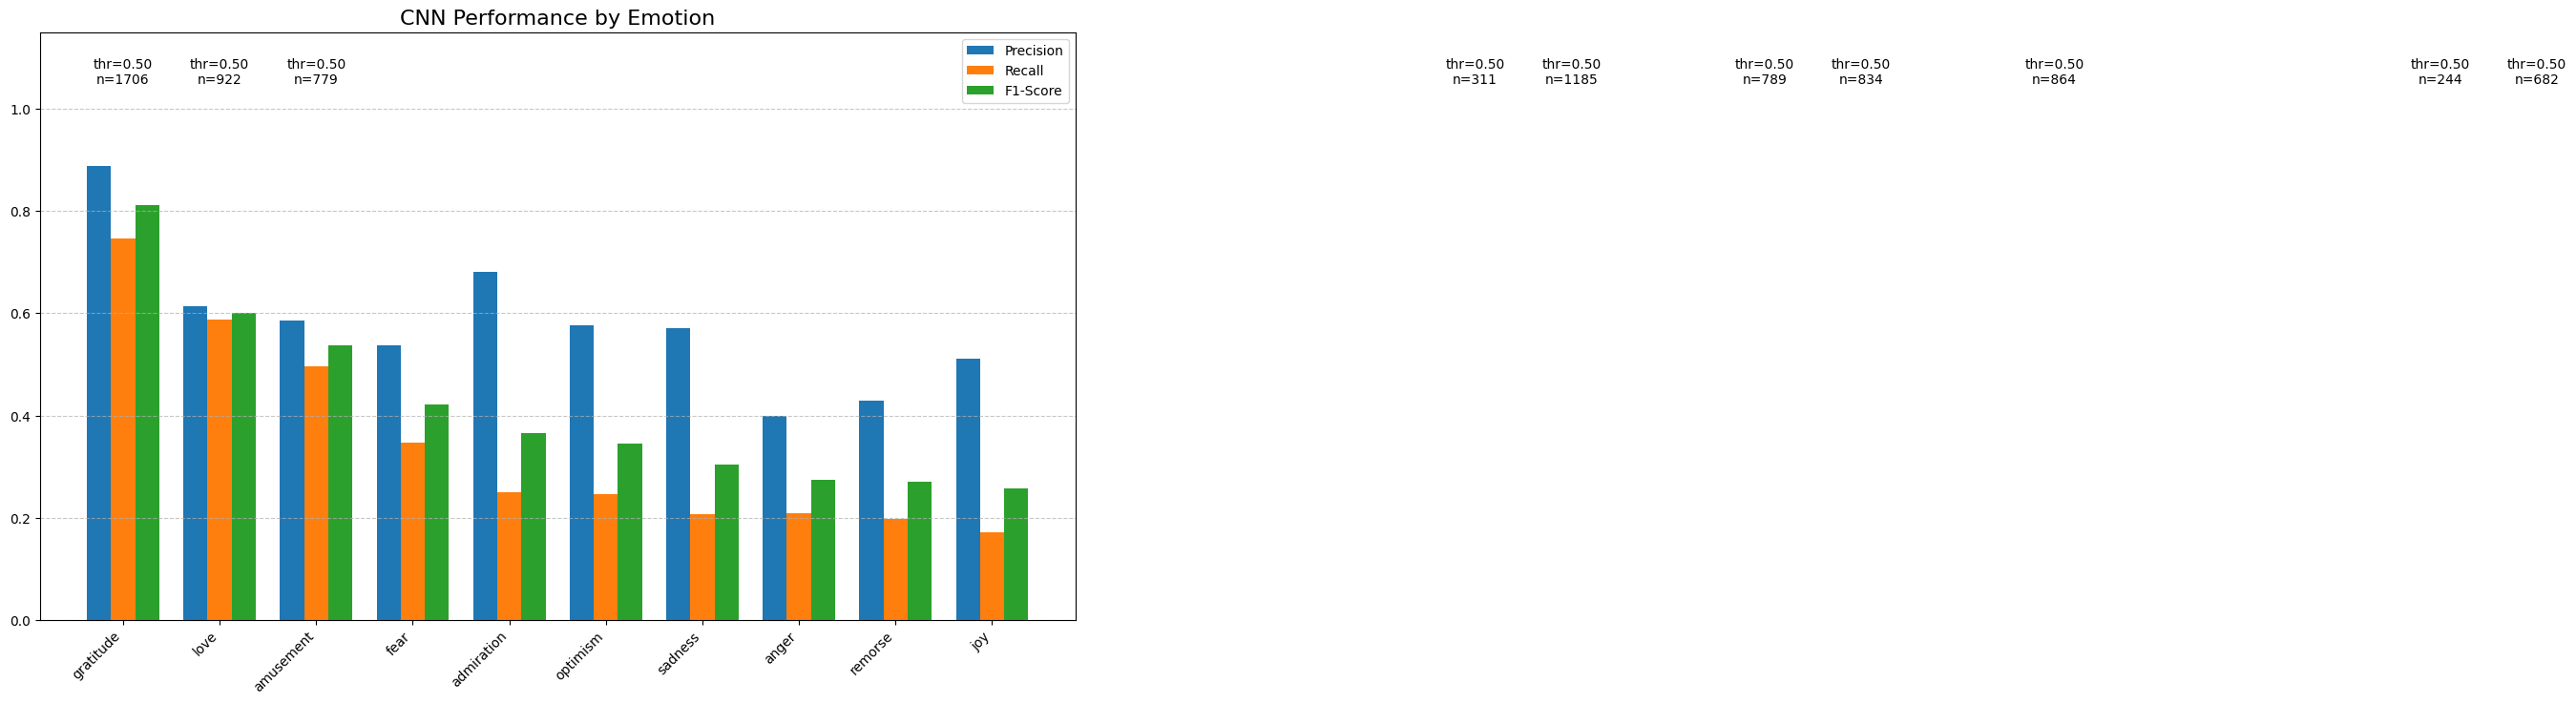

/var/folders/w_/0qjwbm551ls6swp_lf0j1b600000gn/T/ipykernel_1631/816644804.py:48: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


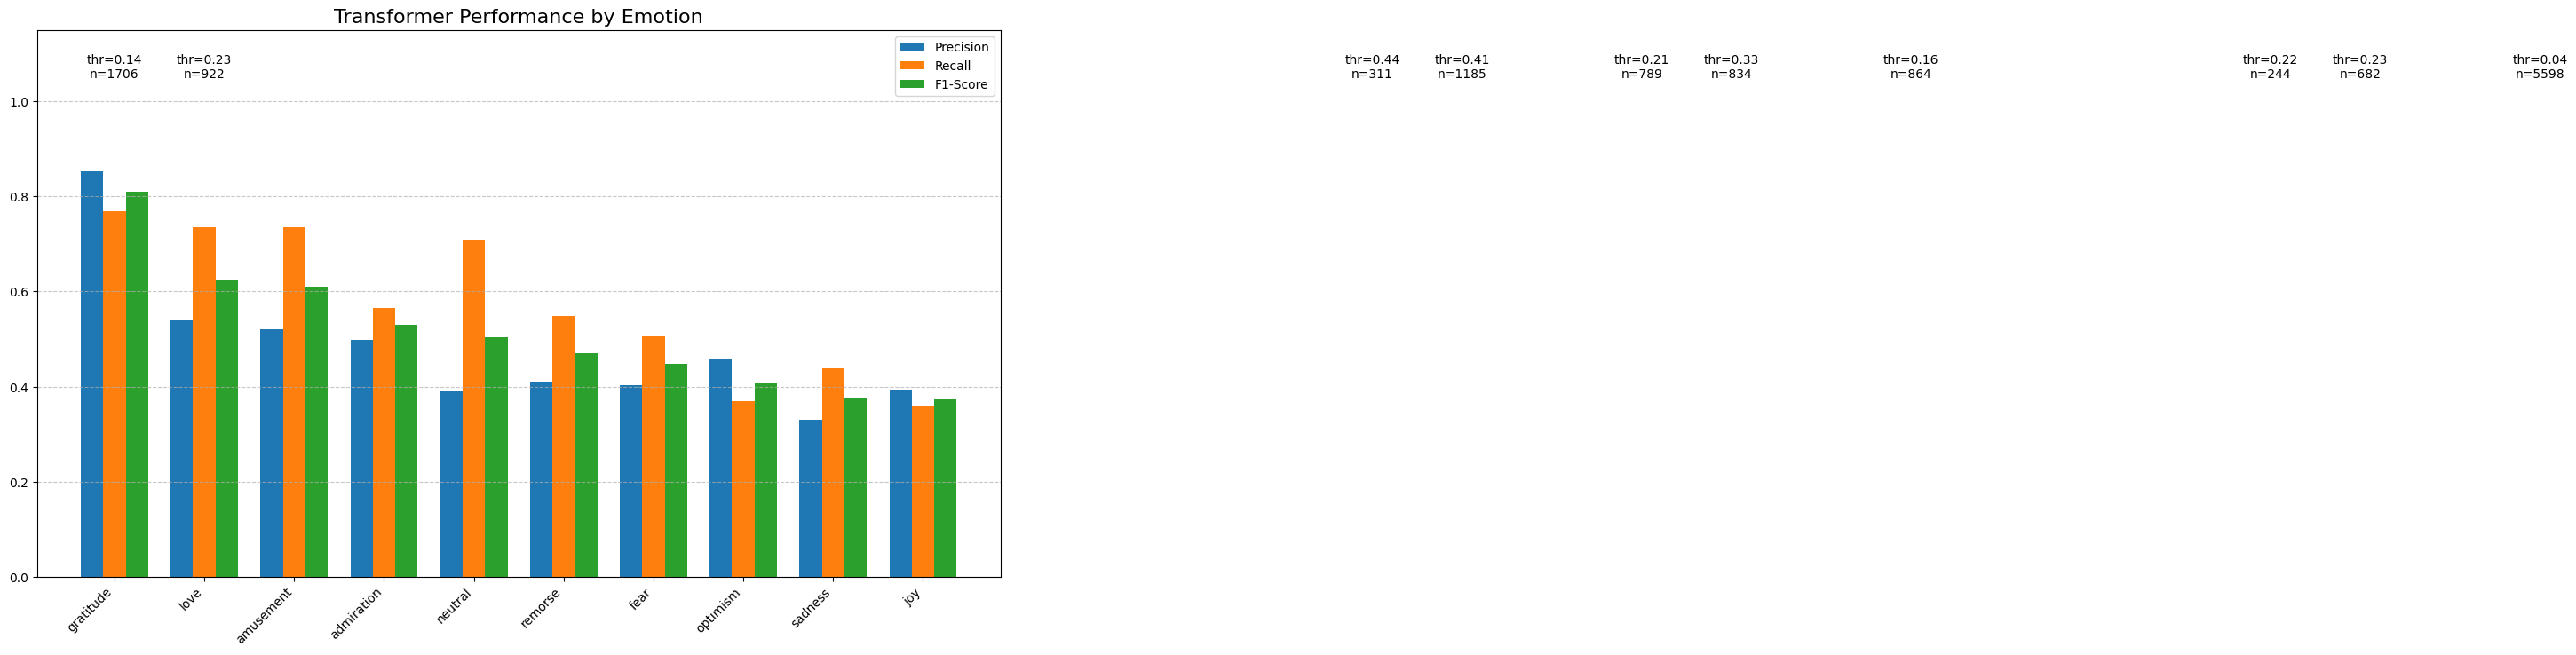

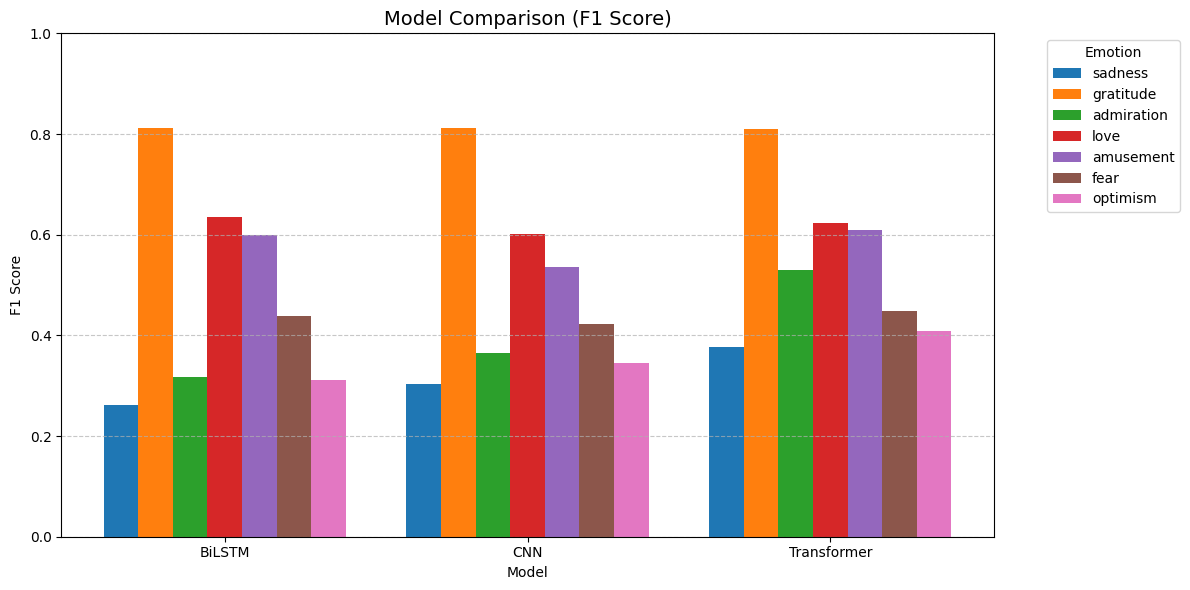

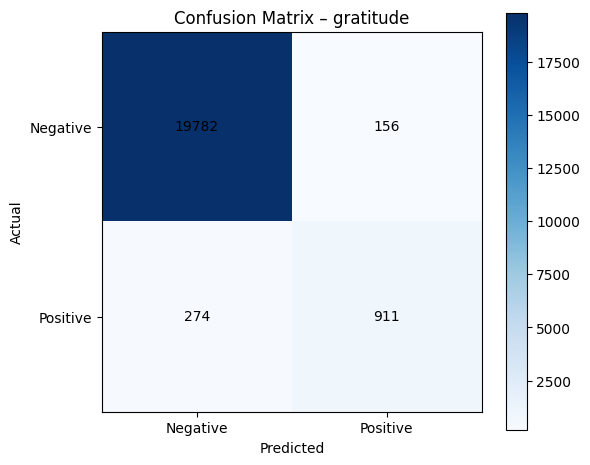

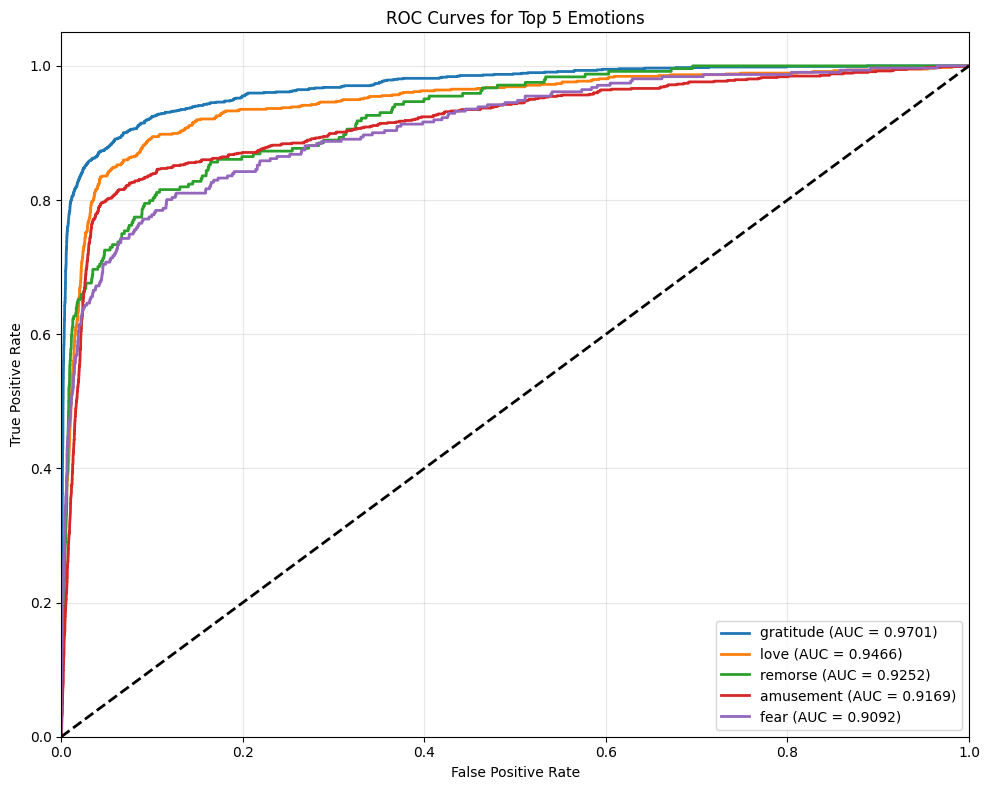


Top 5 classes with most errors:
    Emotion  False Positives  False Negatives  Total_Errors
    neutral             6171             1628          7799
   approval             3221             1116          4337
  annoyance             1487              959          2446
disapproval             1524              743          2267
realization             1573              644          2217


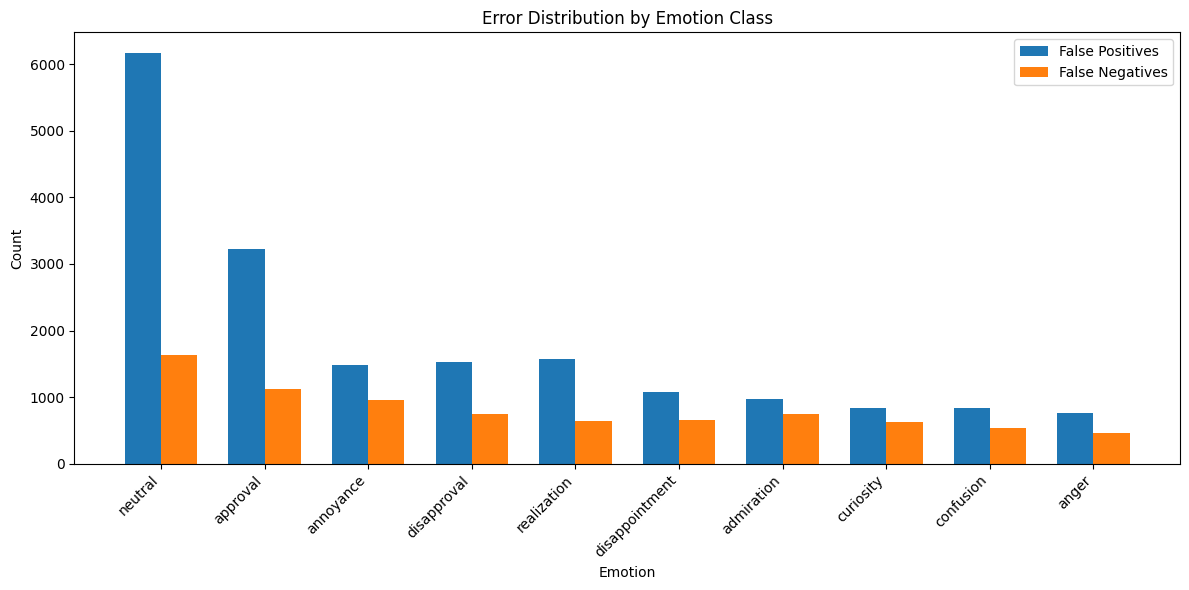


Evaluation complete!


In [35]:
# ───────────────────────────── 13. Run Evaluation ─────────────────────────
if __name__ == "__main__":
    # Uncomment the following lines to run the hyperparameter tuning and cross-validation
    
    # Run hyperparameter tuning for CNN model
    print("\nRunning CNN hyperparameter tuning...")
    # best_cnn_params = hyperparameter_search_cnn_efficient()  # Use efficient version for faster execution
    
    # Now define a build function with the optimal parameters
    # def build_optimal_cnn():
    #     return build_cnn(
    #         emb_dim=best_cnn_params['emb_dim'],
    #         filters=best_cnn_params['filters'],
    #         kernel_sizes=(3, 4, 5)
    #     )
    
    # Run cross-validation on models
    print("\nRunning cross-validation on models...")
    # cv_lstm_results = cross_validate_model_efficient(build_lstm, "BiLSTM")
    # cv_cnn_results = cross_validate_model_efficient(build_optimal_cnn if 'best_cnn_params' in locals() else build_cnn, "CNN")
    
    # Train the final models if not already trained
    print("\nTraining final models...")
    if 'lstm_model' not in globals():
        lstm_model, hist_lstm = train_model(build_lstm, 'LSTM')
    if 'cnn_model' not in globals():
        cnn_model, hist_cnn = train_model(build_cnn, 'CNN')
    if 'tfm_model' not in globals():
        tfm_model, hist_tfm = train_model(build_transformer, 'TFM')
    
    # Comprehensive evaluation
    print("\nRunning comprehensive evaluation...")
    lstm_metrics = evaluate_model_comprehensive(lstm_model, test_x, test_y, label_cols, name="BiLSTM")
    cnn_metrics = evaluate_model_comprehensive(cnn_model, test_x, test_y, label_cols, name="CNN")
    tfm_metrics = evaluate_model_comprehensive(tfm_model, test_x, test_y, label_cols, thresholds=opt_thr, name="Transformer")
    
    # Generate visualizations
    plot_metrics_by_emotion(lstm_metrics, title="BiLSTM Performance by Emotion")
    plot_metrics_by_emotion(cnn_metrics, title="CNN Performance by Emotion")
    plot_metrics_by_emotion(tfm_metrics, title="Transformer Performance by Emotion")
    
    # Compare models
    model_comparison = [("BiLSTM", lstm_metrics), ("CNN", cnn_metrics), ("Transformer", tfm_metrics)]
    plot_model_comparison(model_comparison, title="Model Comparison (F1 Score)")
    
    # Analyze top performing emotion in detail
    top_emotion = tfm_metrics['Emotion'].iloc[0]
    top_idx = label_cols.index(top_emotion)
    top_threshold = opt_thr[top_idx] if opt_thr is not None else 0.5
    
    plot_confusion_matrix_for_class(
        tfm_model, test_x, test_y, 
        top_idx, top_emotion, threshold=top_threshold
    )
    
    # ROC curve analysis
    plot_roc_curves(tfm_model, test_x, test_y, label_cols, top_n=5)
    
    # Error analysis
    error_analysis = analyze_error_patterns(tfm_model, test_x, test_y, label_cols, thresholds=opt_thr)
    
    print("\nEvaluation complete!")

In [30]:
# ───────────────────────────── 14. Save Models for Part 2 ────────────────────
def save_model_for_inference(model, word_index, max_len, label_cols, output_dir):
    """
    Save a model and all necessary preprocessing components for later inference.
    
    Args:
        model: Trained Keras model
        word_index: Dictionary mapping words to indices
        max_len: Maximum sequence length
        label_cols: List of emotion labels
        output_dir: Directory to save model and components
    """
    import os
    import json
    import pickle
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Save the model in Keras format (Keras 3 preferred format)
    model_path = os.path.join(output_dir, "model.keras")
    model.save(model_path)
    print(f"Model saved to {model_path}")
    
    # 2. Save vocabulary (word_index)
    with open(os.path.join(output_dir, "word_index.pkl"), "wb") as f:
        pickle.dump(word_index, f)
    
    # 3. Save label columns
    with open(os.path.join(output_dir, "label_cols.json"), "w") as f:
        json.dump(label_cols, f)
    
    # 4. Save configuration parameters
    config = {
        "max_len": max_len,
        "model_type": model.name if hasattr(model, "name") else "unknown"
    }
    with open(os.path.join(output_dir, "config.json"), "w") as f:
        json.dump(config, f)
    
    # 5. Save optimized thresholds if available
    if 'opt_thr' in globals():
        np.save(os.path.join(output_dir, "opt_thresholds.npy"), opt_thr)
    
    print(f"Model and components saved to {output_dir}")

# Save models for Part 2
save_model_for_inference(lstm_model, word2idx, MAX_LEN, label_cols, "../models/lstm_sentiment")
save_model_for_inference(cnn_model, word2idx, MAX_LEN, label_cols, "../models/cnn_sentiment")
save_model_for_inference(tfm_model, word2idx, MAX_LEN, label_cols, "../models/transformer_sentiment")

Model saved to ../models/lstm_sentiment/model.keras
Model and components saved to ../models/lstm_sentiment
Model saved to ../models/cnn_sentiment/model.keras
Model and components saved to ../models/cnn_sentiment
Model saved to ../models/transformer_sentiment/model.keras
Model and components saved to ../models/transformer_sentiment
